<a href="https://colab.research.google.com/github/theodoragirgis/rebound/blob/main/tle_propagator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TLE Propagator**


A two-line element (TLE) is a data format that encodes orbital elements of an Earth-orbiting object at an epoch. These elements are constantly updated and made publicly available as text files on [NORAD's CelestTrack website](https://www.celestrak.com/NORAD/elements/). This data can be used to propagate an object's orbit around the Earth. 



The TLE format can be described using the example below (**Note: All angles in a TLE are given in degrees**):



In [163]:
from IPython.display import Image
Image(url='https://i.stack.imgur.com/13u3a.gif')

### **Install Dependencies**


In [164]:
!pip install rebound &> /dev/null
!pip install reboundx &> /dev/null
!pip install -U TLE-tools &> /dev/null
!pip install https://github.com/matplotlib/basemap/archive/master.zip &> /dev/null

### **TLEs**

We will use the TLE-tools python library to parse the desired TLE set into parameters that REBOUND can use for integration. 

In [165]:
import tletools

tle_string = """
ISS (ZARYA)             
1 25544U 98067A   21225.08452447  .00001000  00000-0  26368-4 0  9996
2 25544  51.6432  61.3538 0001216 306.1503 200.0188 15.48894829297417
"""

tle_lines = tle_string.strip().splitlines()
tle = tletools.tle.TLE.from_lines(*tle_lines)

We can now easily access all the TLE elements from this object:

In [ ]:
print(tle)

TLE(name='ISS (ZARYA)', norad='25544', classification='U', int_desig='98067A', epoch_year=2021, epoch_day=232.56369815, dn_o2=1.292e-05, ddn_o6=0.0, bstar=3.1665e-05, set_num=999, inc=51.644, raan=24.3628, ecc=0.0001513, argp=335.8493, M=142.2476, n=15.48921672, rev_num=29857)


### **Simulation Setup**

Since TLEs represent Earth orbiting objects, we must add the Earth as a particle to the origin of our simulation. By default, REBOUND simulations use units in which the gravitational constant has a value G = 1. If we want to work using different units, we must set G to match our desired unit system:

In [167]:
import rebound

sim = rebound.Simulation()               
    
# Add Earth particle to the origin (mass = 5.972e24 kg) 
sim.add(m=5.972e24) 

# Set G to match desired units (kg, km, s)
sim.G = 6.67408e-20 

We can add our spacecraft to the simulation by specifying its orbital elements as given in the TLE. We must also make sure to convert all angles to radians.

In [168]:
import numpy as np

# Orbital elements
a = float(tle.a)
e = float(tle.ecc) 
inc = float(tle.inc) * np.pi/180
Omega = float(tle.raan) * np.pi/180
omega = float(tle.argp) * np.pi/180
M = float(tle.M) * np.pi/180

# Additional information
Name = tle.name
epoch = tle.epoch
period = 86400/tle.n

# Add spacecraft on a Keplerian orbit around the Earth
sim.add(a=a, e=e, inc=inc, Omega=Omega, omega=omega, M=M) 
sc = sim.particles[1]

We can also access the spacecraft's orbital elements in REBOUND:

In [169]:
print(sc.orbit)

<rebound.Orbit instance, a=6798.094875846519 e=0.00012159999999987555 inc=0.9013438762659356 Omega=1.070825818610097 omega=5.343330740968339 f=3.4909033834954766>


### **Propagation**

REBOUND can be used to propagate the spacecraft's orbit over a desired period of time and number of integration steps. REBOUND will return the spacecraft's position and velocity at each time step. 

In [170]:
num_steps = 10000
num_orbits = 10

t0 = 0
ts = num_steps
tf = period * num_orbits

t_list = np.linspace(t0,tf,ts)

position, velocity = [], []

for t in t_list:
    sim.integrate(float(t))
    position.append(np.array([sc.x, sc.y, sc.z]))
    velocity.append(np.array([sc.vx, sc.vy, sc.vz]))
    
position, velocity = np.array(position), np.array(velocity)

### **Plot Orbit**

We can use REBOUND's OrbitPlot function to plot our orbit in the xy, xz, and yz planes. Plotting in all three planes allows us to observe the three-dimensional distribution of the spacecraft's motion. 

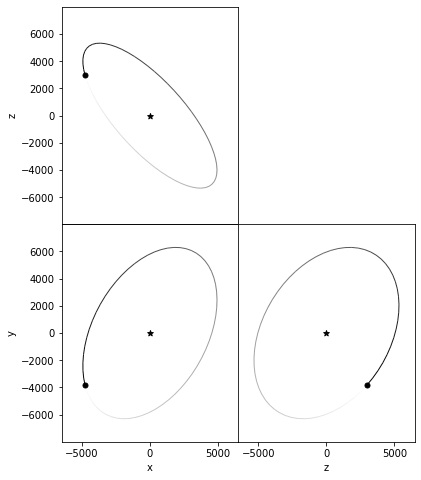

In [171]:
fig = rebound.OrbitPlot(sim,slices=1,xlim=[-2,2],ylim=[-2,2])

We can also use matplotlib to generate a three-dimensional plot of the spacecraft's orbit. 

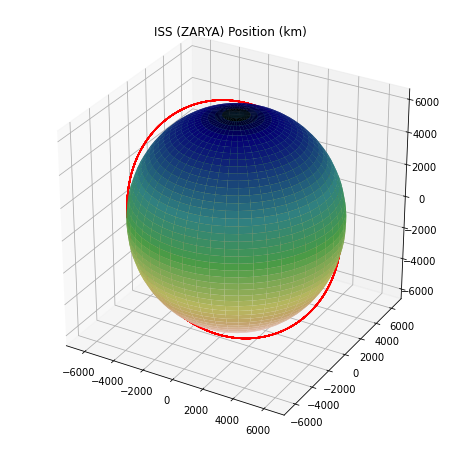

In [172]:
import matplotlib.pyplot as plt

x, y, z = position[:,0], position[:,1], position[:,2]

fig1 = plt.figure(figsize=(8,8))
    
# Spherical coordinates
theta = np.linspace(0, 2*np.pi)
phi = np.linspace(0, np.pi)
    
# Plot Earth 
a = 6371 * np.outer(np.cos(theta), np.sin(phi))
b = 6371 * np.outer(np.sin(theta), np.sin(phi))
c = 6371 * np.outer(np.ones(np.size(theta)), np.cos(phi))

earth = fig1.add_subplot(111, projection = '3d')
earth.plot_surface(a, b, c, cmap='gist_earth_r', linewidth = 0.5)

# Plot position data
earth.plot3D(x, y, z, c = 'red')
earth.set_title(f'{Name} Position (km)')

plt.show()

Matplotlib can also be used to plot the periodic magnitudes of our position and velocity data. 

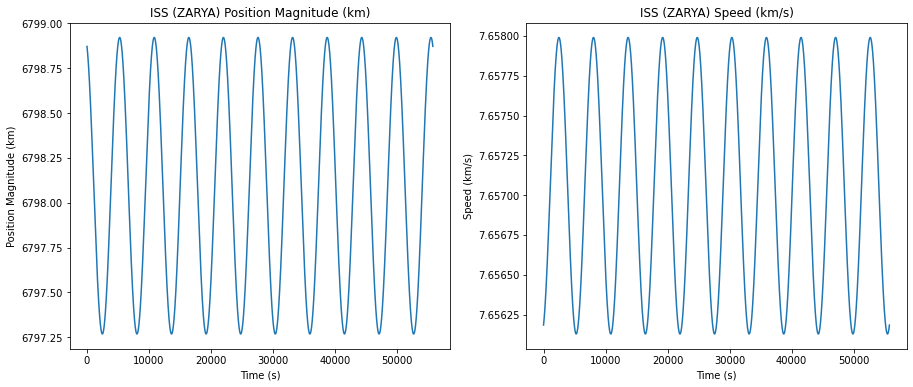

In [173]:
x, y, z = position[:,0], position[:,1], position[:,2]
u, v, w = velocity[:,0], velocity[:,1], velocity[:,2]

mag, p = plt.subplots(nrows=1,ncols=2, figsize=(15,6))

# Plot position magnitude data    
pos = np.sqrt(x**2 + y**2 + z**2)
p[0].plot(t_list, pos)
p[0].set_title(f'{Name} Position Magnitude (km)')
p[0].set_xlabel('Time (s)')
p[0].set_ylabel('Position Magnitude (km)')

# Plot speed data  
speed = np.sqrt(u**2 + v**2 + w**2)
p[1].plot(t_list, speed)
p[1].set_title(f'{Name} Speed (km/s)')
p[1].set_xlabel('Time (s)')
p[1].set_ylabel('Speed (km/s)')
  
plt.show()

### **Orbital Perturbations**

Earth orbiting spacecrafts are subject to several perturbations that cause their motion to deviate from the expected two-body solution. These deviations are caused by factors such as the oblateness of the Earth, atmospheric drag, solar radiation pressure, lunar gravity, and solar gravity. 

**J2 Perturbation**

The perturbing force based on the oblateness of the Earth has the greatest effect on the spacecraft's position and is known as a "J2 perturbation". 

The acceleration due to J2 is given by:

$\vec{a} = \frac{3}{2} \frac{J_2\mu R^2}{r^5} [x(5 \frac{z^2}{r^2} - 1) \hat{i} + y(5 \frac{z^2}{r^2} - 1) \hat{j} + z(5 \frac{z^2}{r^2} - 3) \hat{k}$

where $J_2$ is Earth's J2 constant ($0.00108262668$), $\mu$ is the standard gravitational parameter of Earth ($398600.44189 km^3/s^2$), $R$ is the radius of the Earth ($6378.137 km$), and $r$ is the magnitude of the object's position.

We can use REBOUNDx to incorporate this force into our simulation.

In [174]:
import reboundx

rebx = reboundx.Extras(sim)
gh = rebx.load_force('gravitational_harmonics')
rebx.add_force(gh)
sc.params['J2'] = 1.08262668e-3   # J2 constant
sc.params['R_eq'] = 6378.137      # Attractor radius

Now we integrate our simulation as before:

In [175]:
position, velocity = [], []

for t in t_list:
    sim.integrate(float(t))
    position.append(np.array([sc.x, sc.y, sc.z]))
    velocity.append(np.array([sc.vx, sc.vy, sc.vz]))
    
position, velocity = np.array(position), np.array(velocity)

If we plot the magnitudes of our position and velocity data again, we will see the effects of the J2 perturbing force:

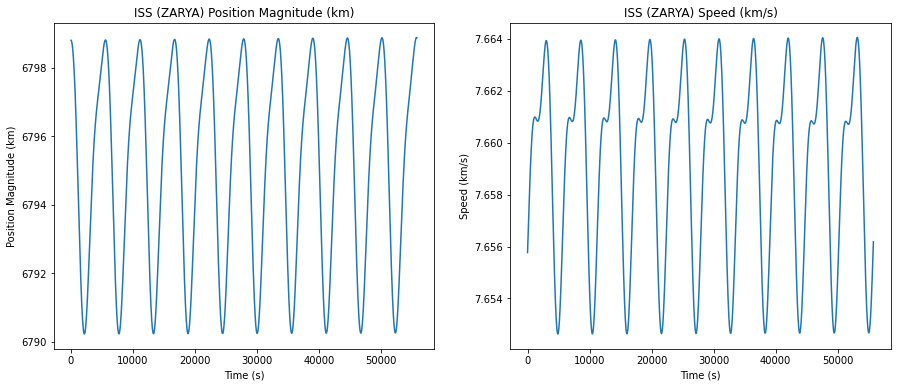

In [176]:
x, y, z = position[:,0], position[:,1], position[:,2]
u, v, w = velocity[:,0], velocity[:,1], velocity[:,2]

mag, p = plt.subplots(nrows=1,ncols=2, figsize=(15,6))

# Plot position magnitude data    
pos = np.sqrt(x**2 + y**2 + z**2)
p[0].plot(t_list, pos)
p[0].set_title(f'{Name} Position Magnitude (km)')
p[0].set_xlabel('Time (s)')
p[0].set_ylabel('Position Magnitude (km)')

# Plot speed data  
speed = np.sqrt(u**2 + v**2 + w**2)
p[1].plot(t_list, speed)
p[1].set_title(f'{Name} Speed (km/s)')
p[1].set_xlabel('Time (s)')
p[1].set_ylabel('Speed (km/s)')
  
plt.show()

**Atmospheric Drag**

Another important perturbing force is atmospheric drag. 

The acceleration due to drag is given by:

$\vec{a} = \frac{1}{2} \rho \frac{C_dA}{m}|\vec{v}|\vec{v}$

where $\rho$ is the air density, $C_d$ is the drag coefficient of the object, $A$ is its frontal area, $m$ is its mass, and $\vec{v}$ is its velocity.

The limitation with adding atmospheric drag to an orbital simulation is the difficulty in analytically modelling air density. The simple exponential model that is used by some propagators is denoted by:

$\rho = \rho_0 e^{-\frac{r-R}{H_0}}$

where $\rho_0$ is the reference density at sea level ($1.225 kg/m^3$), $r$ is the magnitude of the object's position, $R$ is the radius of the Earth, and $H_0$ is Earth's atmospheric scale height ($8.5km$). 

This model, however, is only good up to altitudes around 10km. Beyond that, we can try to derive a better model by fitting a curve to data from the ["U.S. Standard Atmosphere 1976" tables](http://www.braeunig.us/space/atmos.htm). 

In [177]:
# Altitudes up to 80km
alt1 = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80])

# Altitudes from 100km to 1000km
alt2 = np.arange(100, 1001, 50)

# Altitudes from 1250km to 2000km
alt3 = np.array([1250, 1500, 2000])

# Altitude array
alt = np.concatenate((alt1, alt2, alt3))


# Density (kg/m^3) for altitudes up to 80km 
rho1 = np.array([1.225, 1.11164, 1.00649, 9.09122e-1, 8.19129e-1, 7.36116e-1, 6.59697e-1, 5.89501e-1, 5.25168e-1, 4.66348e-1, 4.12707e-1, 3.10828e-1, 1.93674e-1, 8.80349e-2, 3.94658e-2, 1.80119e-2, 8.21392e-3, 3.85101e-3, 1.88129e-3, 9.77525e-4, 2.88321e-4, 7.42430e-5, 1.57005e-5])

# Density (kg/m^3) for altitudes between 100km and 1000km
rho2 = np.array([5.25e-7, 1.73e-9, 2.41e-10, 5.97e-11, 1.87e-11, 6.66e-12, 2.62e-12, 1.09e-12, 4.76e-13, 2.14e-13, 9.89e-14, 4.73e-14, 2.36e-14, 1.25e-14, 6.95e-15, 4.22e-15, 2.78e-15, 1.98e-15, 1.49e-15])

# Density (kg/m^3) for altitudes between 1250km and 2000km
rho3 = np.array([5.70e-16, 2.79e-16, 9.09e-17])

# Density array
rho = np.concatenate((rho1, rho2, rho3))

Plotting this data using a logarithmic scale provides us with a clear picture of the altitude-density relation. 

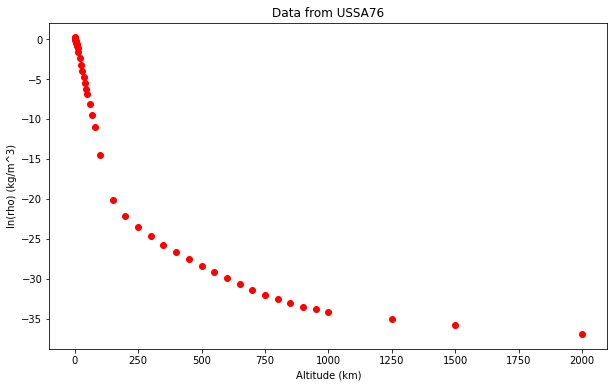

In [178]:
fig = plt.figure(figsize=(10, 6))
plt.scatter(alt, np.log(rho), c = 'red')
plt.title('Data from USSA76')
plt.xlabel('Altitude (km)')
plt.ylabel('ln(rho) (kg/m^3)')
plt.show()

As expected, we observe a linear relation for lower altitudes; however, the curve takes on a decaying exponential shape at higher altitudes. As a result, we can try to fit an exponential function to the data and compare this new model with the simple exponential model. 

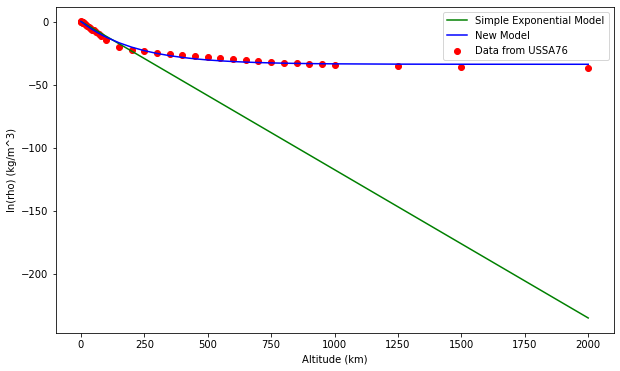

New Model: rho = exp(33.97683773402465*exp(-alt/218.12544544088206)-33.767889057132486)


In [179]:
from scipy import optimize

# Exponential curve fit
def f(x, a, b, c):
    return a * np.exp(-x/b) + c  
params, covariance = optimize.curve_fit(f, alt, np.log(rho))


fig = plt.figure(figsize=(10, 6))
plt.scatter(alt, np.log(rho), c = 'red', label = 'Data from USSA76')
plt.plot(alt, -alt/8.5 + np.log(1.225), c = 'green', label='Simple Exponential Model')
plt.plot(alt, f(alt, params[0], params[1], params[2]), c = 'blue', label='New Model')
plt.xlabel('Altitude (km)')
plt.ylabel('ln(rho) (kg/m^3)')
plt.legend()
plt.show()

print(f'New Model: rho = exp({params[0]}*exp(-alt/{params[1]}){params[2]})')

Our new density relation is:

$\rho = e^{33.97683773402465e^{-\frac{r-R}{218.12544544088206}} - 33.767889057132486}$

While this model is still not perfect, it is significantly better for simulating orbits from TLEs since most spacecrafts orbiting the Earth do so at altitudes between $160km$ and $2000km$.

We can set up a new simulation to verify the isolated effect of drag on the spacecraft's motion.

In [180]:
sim_drag = rebound.Simulation()                
sim_drag.add(m=5.972e24) 
sim_drag.G = 6.67408e-20 

# Orbital elements
a = float(tle.a)
e = float(tle.ecc) 
inc = float(tle.inc) * np.pi/180
Omega = float(tle.raan) * np.pi/180
omega = float(tle.argp) * np.pi/180
M = float(tle.M) * np.pi/180

sim_drag.add(a=a, e=e, inc=inc, Omega=Omega, omega=omega, M=M) 
sc_drag = sim_drag.particles[1]

The atmospheric drag force is not already implemented in REBOUND or REBOUNDx but we can still add it to our simulation. 
First, we need to define a function that updates the spacecraft's acceleration:

In [181]:
rebx_drag = reboundx.Extras(sim_drag)

def atmospheric_drag(reb_sim, rebx_force, particles, N):

  sim = reb_sim.contents
  atmos_drag = rebx_force.contents

  pos_vec = np.array([particles[1].x, particles[1].y, particles[1].z])
  pos = np.sqrt(pos_vec[0]**2 + pos_vec[1]**2 + pos_vec[2]**2)
  vel_vec = np.array([particles[1].vx, particles[1].vy, particles[1].vz])
  vel = np.sqrt(vel_vec[0]**2 + vel_vec[1]**2 + vel_vec[2]**2)

  alt = pos - 6378.137

  # Atmospheric density model
  rho = np.exp(33.97683773402465 * np.exp(-alt/218.12544544088206) - 33.767889057132486)

  # Convert density to kg/km^3 to match simulation units
  rho = rho*1e9

  # Update acceleration
  particles[1].ax += -1/2*rho*(C_d*A/m)*vel*vel_vec[0]
  particles[1].ay += -1/2*rho*(C_d*A/m)*vel*vel_vec[1]
  particles[1].az += -1/2*rho*(C_d*A/m)*vel*vel_vec[2]

Now, we can create the velocity dependent drag force and add it to our simulation using the `create_force()` function in REBOUNDx.

In [182]:
atmos_drag = rebx_drag.create_force('atmospheric drag')
atmos_drag.force_type = 'vel'
atmos_drag.update_accelerations = atmospheric_drag
rebx_drag.add_force(atmos_drag)

Our simulation now requires several additional parameters: $C_d$, $A$, and $m$. 

Since our example TLE is for the International Space Station (ISS), this information is available through a quick search:

In [183]:
C_d = 2.07  # Drag coefficient (dimensionless)
A = 0.0007  # Frontal area (km^2)
m = 420000  # Mass (kg)

Finally, we integrate our simulation as before, this time keeping track of the mean motion:

In [184]:
mean_motion = []

for t in t_list:
    sim_drag.integrate(float(t))
    mean_motion.append(sc_drag.n)
    
mean_motion = np.array(mean_motion)

We can verify that we have correctly implemented this force by comparing the first derivative of mean motion from our REBOUND simulation with that given in the TLE.

Note that the value given in the TLE is equal to the first derivative of mean motion divided by 2 and is in units of $rev/day^2$, so we must first convert it to units of $rad/s^2$. 

In [185]:
# First derivative of mean motion via TLE
n_dot = 2*tle.dn_o2*2*np.pi/(86400**2) 

# First derivative of mean motion via REBOUND simulation
slope, intercept = np.polyfit(t_list, mean_motion, 1)

print(f'First derivative of mean motion via TLE:\t {n_dot}')
print(f'First derivative of mean motion via REBOUND:\t {slope}')

First derivative of mean motion via TLE:	 1.683380837185889e-14
First derivative of mean motion via REBOUND:	 1.3690082053286305e-14


The two slopes are on the same order of magnitude which indicates an acceptable atmospheric drag model. We can now add this force to our previous simulation and integrate:

In [186]:
atmos_drag = rebx.create_force('atmospheric drag')
atmos_drag.force_type = 'vel'
atmos_drag.update_accelerations = atmospheric_drag
rebx.add_force(atmos_drag)

position, velocity = [], []

for t in t_list:
    sim.integrate(float(t))
    position.append(np.array([sc.x, sc.y, sc.z]))
    velocity.append(np.array([sc.vx, sc.vy, sc.vz]))
    
position, velocity = np.array(position), np.array(velocity)

Our final simulation now accounts for two-body forces, J2 perturbation, and atmospheric drag. 

### **Coordinate Systems**

Specifying a coordinate system allows us to keep track of an object's position in space; however, different systems are useful for different applications. Three of the most commonly used coordinate systems for orbit analysis are described below:

***Earth-Centered Inertial (ECI) Coordinate System***

The ECI system has its origin at the center of the Earth and is fixed in space. 
*   The $x_{ECI}$ axis points towards the vernal equinox (the line from the Earth to the Sun on the first day of Spring)
*   The $y_{ECI}$ axis points 90 degrees east of the x-axis in the equatorial plane
*   The $z_{ECI}$ axis points towards the North Pole, in the direction of Earth's rotation axis

***Earth-Centered Earth-Fixed (ECEF) Coordinate System***

The ECEF system has its origin at the center of the Earth and rotates with the Earth. 
*   The $x_{ECEF}$ axis points towards the intersection of the equatorial plane (0 degree latitude) and the Prime Meridian (0 degree longitude)
*   The $y_{ECEF}$ axis points 90 degrees east of the x-axis in the equatorial plane
*   The $z_{ECEF}$ axis points towards the North Pole, in the direction of Earth's rotation axis

***Geographic Coordinate System (GCS)***

Rather than using x, y, z coordinates, the GCS system uses latitude and longitude coordinates. 
*   The Equator has a 0 degree latitude, while the North and South Poles have 90 and -90 degree latitudes respectively. The latitude of a point on Earth's surface describes its distance North or South of the Equator.
*   The Prime Meridian has a 0 degree longitude. The longitude of a point on Earth's surface describes its distance East or West of the Prime Meridian.

### **Ground track**

For an Earth orbiting spacecraft, it is useful to have information about its position relative to the Earth's surface. In order to do this, we need to convert our data into a geographic coordinate system.

**REBOUND returns position and velocity data in the ECI frame**, so we must first convert this data into the ECEF frame, then to the geographic frame.

**ECI to ECEF Coordinate Conversion**

The $x_{ECEF}$ axis rotates about the $z_{ECI} = z_{ECEF}$ axis. The angle that it makes with the $x_{ECI}$ axis is known as the Earth Rotation Angle (ERA). To convert between the ECI and ECEF frames, we first need to find the ERA, denoted as $\gamma[0, 2\pi]$.

The ERA is known to be $280.46^{\circ}$ at J2000 (noon terrestrial time on January 1st 2000). Using the elapsed time since J2000, we can find the ERA at a time of interest by multiplying the Earth rotation rate ($360.985...^{\circ}/day$) by the elapsed time in days, $\Delta T$, and adding it to $280.46^{\circ}$ which is the ERA at $\Delta T = 0$. This calculation is summarized by the formula below:

$\gamma = 360.9856123035484 \times \Delta T + 280.46$

We can use the astropy `Time` module to convert our time array from seconds since epoch to Julian days since J2000. Next, we can calculate the accompanying array of ERAs, making sure to convert from degrees to radians. 

In [187]:
from astropy.time import Time 

t_days = t_list/86400
dJulian = Time(t_days + epoch.jd, format="jd", scale="tdb")
dT = dJulian.value - 2451545    # 2451545 is the Julian day for J2000

ERA = (360.9856123035484 * dT + 280.46) % 360
ERA = np.radians(ERA)

Earth's motion in the ECI frame results from rotation, precession, and nutation. However, the latter two are insignificant in the short term and will be ignored in the following computation. 

To convert a vector from the ECI to the ECEF frame, we rotate it about the x-axis by the ERA, $\gamma$, using the following rotational matrix:

$M_{ECI}^{ECEF} = \begin{pmatrix}cos\gamma & -sin\gamma & 0 \\ sin\gamma & cos\gamma & 0 \\ 0 & 0 & 1\end{pmatrix}$


In [188]:
x_ECI = position[:,0]
y_ECI = position[:,1]
z_ECI = position[:,2]

position_ECEF = np.zeros((len(position), 3))
A11 = np.cos(-ERA)
A12 = -np.sin(-ERA)
A21 = np.sin(-ERA)
A22 = np.cos(-ERA)
position_ECEF[:,0] = np.add(np.multiply(A11, x_ECI), np.multiply(A12, y_ECI))
position_ECEF[:,1] = np.add(np.multiply(A21, x_ECI), np.multiply(A22, y_ECI))
position_ECEF[:,2] = z_ECI

**ECEF to Geographic Coordinate Conversion**

Converting from the ECEF frame to the geographic frame is simple since both are fixed with respect to the Earth. 

We begin by converting from cartesian to spherical coordinates using the following relations:

$\phi = tan^{-1}(\frac{y}{x}) \qquad \theta = cos^{-1}(\frac{z}{\sqrt{(x^2 + y^2 + z^2)}})$

In [189]:
x_ECEF = position_ECEF[:,0]
y_ECEF = position_ECEF[:,1]
z_ECEF = position_ECEF[:,2]

phi = np.degrees(np.arccos(np.divide(z_ECEF, np.sqrt(x_ECEF**2 + y_ECEF**2 + z_ECEF**2))))
theta = np.degrees(np.arctan(np.divide(y_ECEF, x_ECEF)))

Then, latitude and longitude can be calculated like so:

$latitude = 90^{\circ} - \phi \qquad longitude = \theta$

We must make sure that our latitude values are in the interval $[-90^{\circ}, +90^{\circ}]$ and that our longitude values are in the interval $[-180^{\circ}, +180^{\circ}]$.

In [190]:
lat = 90 - phi

theta[np.where(x_ECEF < 0)[0]] = theta[np.where(x_ECEF < 0)[0]] - 180
lon = theta
lon[np.where(lon < 180)[0]] = theta[np.where(lon < 180)[0]] + 360
lon[np.where(lon > 180)[0]] = theta[np.where(lon > 180)[0]] - 360

**Plot ground track**

We can use the Matplotlib Basemap Toolkit to plot a map of the Earth's surface in order to better visualize our spacecraft's ground track.

Text(0, 0.5, 'Latitude')

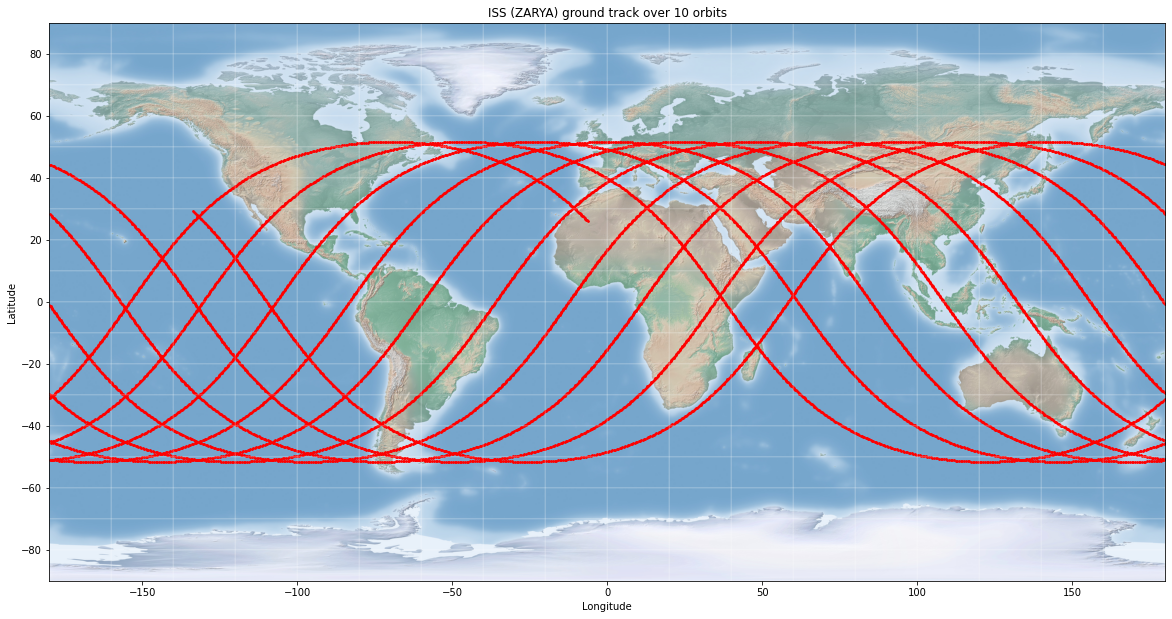

In [191]:
from mpl_toolkits.basemap import Basemap
from itertools import chain

# Plot Earth map
fig = plt.figure(figsize=(20, 18), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, suppress_ticks=False)

m.shadedrelief(scale=0.2)
    
lats = m.drawparallels(np.linspace(-90, 90, 19))
lons = m.drawmeridians(np.linspace(-180, 180, 19))

lat_lines = chain(*(tup[1][0] for tup in lats.items()))
lon_lines = chain(*(tup[1][0] for tup in lons.items()))
all_lines = chain(lat_lines, lon_lines)

for line in all_lines:
  line.set(linestyle='-', alpha=0.3, color='w')


# Plot ground track
plt.scatter(lon, lat, c = 'r', s = 3)

plt.title(f'{Name} ground track over {num_orbits} orbits')
plt.xlabel('Longitude')
plt.ylabel('Latitude')